# TensorFlow 모델 및 데이터셋 다운로드
### 1. Keras의 fine-tuned 모델을 Hugging Face로부터 다운로드

### 2. cifar-10 공개 데이터셋을 Hugging Face로부터 다운로드

In [12]:
!pip install -q huggingface_hub
!pip install pynvml

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from huggingface_hub import from_pretrained_keras
import psutil
import time
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings('ignore')

print("✅ 라이브러리 임포트 완료!")
print(f"📌 TensorFlow 버전: {tf.__version__}")

# GPU 확인
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"🎮 GPU 사용 가능: {len(gpus)}개")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"   - {gpu.name}")
else:
    print("💻 CPU 모드로 실행됩니다")

✅ 라이브러리 임포트 완료!
📌 TensorFlow 버전: 2.19.0
🎮 GPU 사용 가능: 1개
   - /physical_device:GPU:0


In [13]:
# pynvml은 NVIDIA GPU만 지원합니다. Colab T4 GPU에서 정상 동작합니다.
try:
    import pynvml
    pynvml.nvmlInit()
    NVIDIA_GPU_AVAILABLE = True
except (ImportError, pynvml.NVMLError):
    NVIDIA_GPU_AVAILABLE = False
    print("NVIDIA GPU 또는 pynvml 라이브러리를 찾을 수 없습니다.")

In [14]:
class ResourceMonitor:
    """리소스 모니터링 클래스"""
    def __init__(self):
        self.process = psutil.Process()
        self.has_gpu = len(tf.config.list_physical_devices('GPU')) > 0

    def get_stats(self):
        cpu_percent = self.process.cpu_percent(interval=0.1)
        memory_mb = self.process.memory_info().rss / 1024 / 1024

        gpu_memory = 0
        if self.has_gpu:
            try:
                gpu_memory = tf.config.experimental.get_memory_info('GPU:0')['current'] / 1024 / 1024
            except:
                pass

        return {
            'cpu_percent': cpu_percent,
            'memory_mb': memory_mb,
            'gpu_memory_mb': gpu_memory
        }

def print_section(title, emoji="📌"):
    """섹션 제목 출력"""
    print("\n" + "="*80)
    print(f"{emoji} {title}")
    print("="*80)

def get_model_size(model_path):
    """모델 파일 크기 계산 (MB)"""
    if os.path.isfile(model_path):
        return os.path.getsize(model_path) / (1024 * 1024)
    elif os.path.isdir(model_path):
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(model_path):
            for filename in filenames:
                filepath = os.path.join(dirpath, filename)
                total_size += os.path.getsize(filepath)
        return total_size / (1024 * 1024)
    return 0

print("✅ 유틸리티 함수 정의 완료!")

✅ 유틸리티 함수 정의 완료!


In [15]:
# ============================================================================
# ⚙️  개선된 리소스 모니터 클래스
# ============================================================================

class AdvancedResourceMonitor:
    """
    psutil과 pynvml을 사용하여 CPU, GPU, 메모리 사용량을 보다 정확하게 측정하는 클래스.
    """
    def __init__(self):
        self.process = psutil.Process()
        self.cpu_cores = psutil.cpu_count(logical=True)
        self.start_stats = {}

        self.gpu_handle = None
        if NVIDIA_GPU_AVAILABLE and pynvml.nvmlDeviceGetCount() > 0:
            self.gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        else:
            self.gpu_handle = None

    def start(self):
        """측정 시작점 기록"""
        self.process.cpu_percent(interval=None)
        self.start_stats['time'] = time.time()

    def stop(self):
        """측정 종료 및 결과 계산"""
        end_time = time.time()

        cpu_percent = self.process.cpu_percent(interval=None) / self.cpu_cores
        memory_mb = self.process.memory_info().rss / 1024 / 1024

        gpu_util = 0
        gpu_memory_mb = 0
        if self.gpu_handle:
            try:
                gpu_info = pynvml.nvmlDeviceGetUtilizationRates(self.gpu_handle)
                gpu_util = gpu_info.gpu
                mem_info = pynvml.nvmlDeviceGetMemoryInfo(self.gpu_handle)
                gpu_memory_mb = mem_info.used / 1024 / 1024
            except pynvml.NVMLError:
                # Colab에서 간헐적으로 발생하는 오류 방지
                pass

        return {
            'inference_time_sec': end_time - self.start_stats['time'],
            'avg_cpu_percent': cpu_percent,
            'ram_mb': memory_mb,
            'avg_gpu_util_percent': gpu_util,
            'gpu_ram_mb': gpu_memory_mb
        }

In [19]:
def print_results(stats, num_images):
    """측정 결과 출력 함수"""
    total_time = stats['inference_time_sec']
    avg_time_ms = total_time / num_images * 1000

    print(f"⏱️  총 추론 시간:         {total_time:.3f}초")
    print(f"⚡ 이미지당 평균 시간:    {avg_time_ms:.2f}ms")
    print(f"💻 평균 CPU 사용률:       {stats['avg_cpu_percent']:.1f}%")
    print(f"🧠 프로세스 RAM 사용량:   {stats['ram_mb']:.1f}MB")
    if NVIDIA_GPU_AVAILABLE:
        print(f"🎮 평균 GPU 사용률:       {stats['avg_gpu_util_percent']:.1f}%")
        print(f"📊 GPU 메모리 사용량:    {stats['gpu_ram_mb']:.1f}MB")
    print("="*50)

In [16]:
# ============================================================================
# 📊 3. CIFAR-10 데이터셋 로드
# ============================================================================

print_section("CIFAR-10 데이터셋 로드", "📊")

# CIFAR-10 클래스 이름
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# CIFAR-10 데이터셋 로드
print("⏳ CIFAR-10 데이터셋 다운로드 중...")
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"\n✅ 다운로드 완료!")
print(f"   📦 학습 데이터: {x_train.shape}")
print(f"   📦 테스트 데이터: {x_test.shape}")
print(f"   📐 이미지 크기: 32x32x3 (RGB)")
print(f"   🏷️ 클래스 수: {len(class_names)}개")

# 클래스별 샘플 수 확인
unique, counts = np.unique(y_test, return_counts=True)
print(f"\n📊 테스트 데이터 클래스 분포:")
for cls, count in zip(unique, counts):
    print(f"   {class_names[cls]}: {count}개")

# # 샘플 이미지 시각화
# print("\n🖼️ 샘플 이미지:")
# fig, axes = plt.subplots(2, 5, figsize=(15, 6))
# axes = axes.ravel()

# for idx in range(10):
#     axes[idx].imshow(x_test[idx])
#     axes[idx].set_title(f"{class_names[y_test[idx][0]]}", fontsize=12, fontweight='bold')
#     axes[idx].axis('off')

# plt.tight_layout()
# plt.show()


📊 CIFAR-10 데이터셋 로드
⏳ CIFAR-10 데이터셋 다운로드 중...

✅ 다운로드 완료!
   📦 학습 데이터: (50000, 32, 32, 3)
   📦 테스트 데이터: (10000, 32, 32, 3)
   📐 이미지 크기: 32x32x3 (RGB)
   🏷️ 클래스 수: 10개

📊 테스트 데이터 클래스 분포:
   airplane: 1000개
   automobile: 1000개
   bird: 1000개
   cat: 1000개
   deer: 1000개
   dog: 1000개
   frog: 1000개
   horse: 1000개
   ship: 1000개
   truck: 1000개


In [17]:
# ============================================================================
# 🤖 4. 사전학습된 모델 다운로드
# ============================================================================

print_section("사전학습된 모델 다운로드", "🤖")

print("⏳ Hugging Face에서 keras-io/supervised-contrastive-learning-cifar10 모델 다운로드 중...")
print("   (ResNet50V2 기반, Supervised Contrastive Learning으로 학습)")

try:
    model = from_pretrained_keras("keras-io/supervised-contrastive-learning-cifar10")
    print("\n✅ 모델 다운로드 및 로드 완료!")
except Exception as e:
    print(f"\n❌ 모델 로드 실패: {e}")
    raise

# 모델 정보 출력
print(f"\n📋 모델 정보:")
print(f"   🏗️ 아키텍처: ResNet50V2 + Supervised Contrastive Learning")
print(f"   🔢 총 파라미터: {model.count_params():,}")
print(f"   📐 입력 shape: {model.input_shape}")
print(f"   📤 출력 shape: {model.output_shape}")

# 모델 구조 출력
print("\n📋 모델 구조:")
model.summary()

# 모델 저장
model_path = 'cifar10_contrastive_model'
model.save(model_path)
keras_size = get_model_size(model_path)
print(f"\n💾 Keras 모델 저장 완료: {model_path}")
print(f"   📦 모델 크기: {keras_size:.2f} MB")


🤖 사전학습된 모델 다운로드
⏳ Hugging Face에서 keras-io/supervised-contrastive-learning-cifar10 모델 다운로드 중...
   (ResNet50V2 기반, Supervised Contrastive Learning으로 학습)


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]


✅ 모델 다운로드 및 로드 완료!

📋 모델 정보:
   🏗️ 아키텍처: ResNet50V2 + Supervised Contrastive Learning
   🔢 총 파라미터: 24,619,025
   📐 입력 shape: (None, 32, 32, 3)
   📤 출력 shape: (None, 10)

📋 모델 구조:
Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functiona  (None, 2048)              23564807  
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         



🔧 데이터 전처리
⏳ 데이터 정규화 중...

✅ 전처리 완료!
   📐 테스트 이미지 shape: (10000, 32, 32, 3)
   📊 원본 데이터 범위: [0, 255]
   📊 전처리 데이터 범위: [0.00, 255.00]

🖼️ 전처리된 샘플 이미지 (10개 클래스):


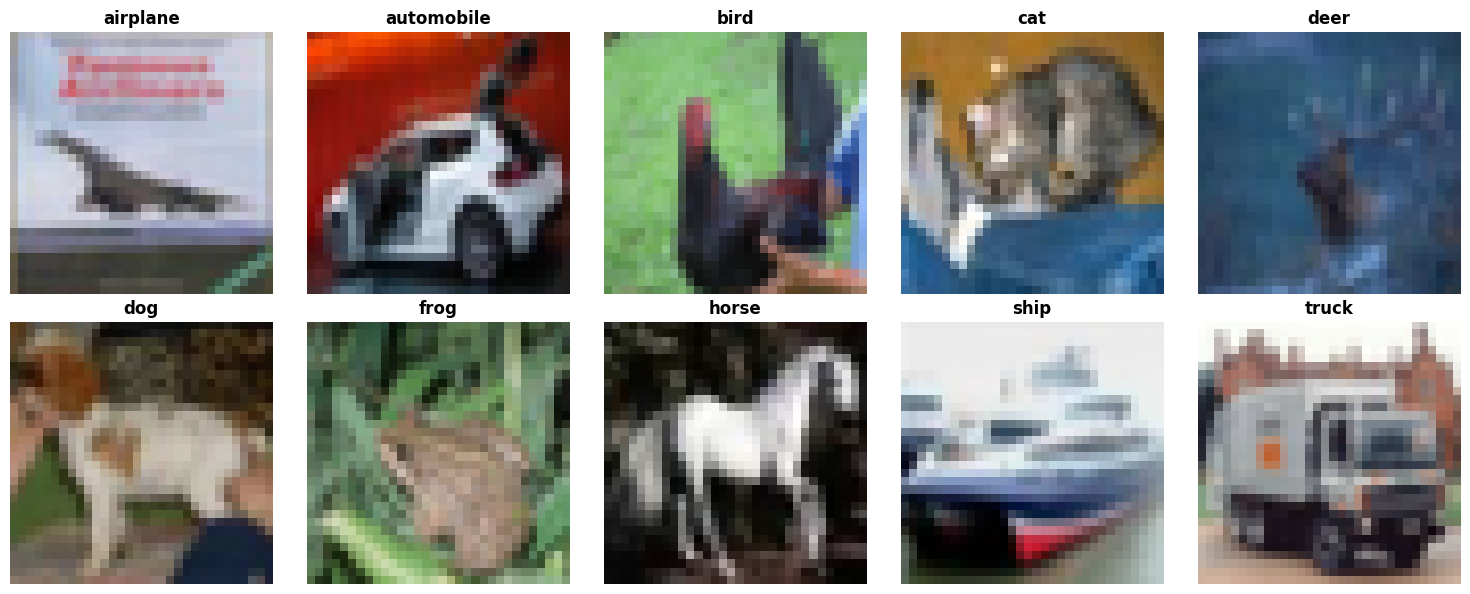

In [18]:
# ============================================================================
# 🔧 5. 데이터 전처리
# ============================================================================

print_section("데이터 전처리", "🔧")

# CIFAR-10 데이터 전처리 (정규화)
print("⏳ 데이터 정규화 중...")
x_test_normalized = x_test.astype('float32')

print(f"\n✅ 전처리 완료!")
print(f"   📐 테스트 이미지 shape: {x_test_normalized.shape}")
print(f"   📊 원본 데이터 범위: [{x_test.min()}, {x_test.max()}]")
print(f"   📊 전처리 데이터 범위: [{x_test_normalized.min():.2f}, {x_test_normalized.max():.2f}]")

# 전처리된 샘플 이미지 확인
print("\n🖼️ 전처리된 샘플 이미지 (10개 클래스):")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# 각 클래스별로 하나씩 샘플 표시
for cls_idx in range(10):
    # 해당 클래스의 첫 번째 이미지 찾기
    sample_idx = np.where(y_test == cls_idx)[0][0]

    # 정규화된 이미지를 원본 스케일로 변환하여 시각화
    display_img = x_test_normalized[sample_idx] / 255.0

    axes[cls_idx].imshow(display_img)
    axes[cls_idx].set_title(f"{class_names[cls_idx]}", fontsize=12, fontweight='bold')
    axes[cls_idx].axis('off')

plt.tight_layout()
plt.show()

In [20]:
# ============================================================================
# 🧪 6. Keras 모델 테스트
# ============================================================================

print_section("Keras 모델 성능 테스트", "🧪")

monitor = AdvancedResourceMonitor()

# 워밍업
print("⏳ 워밍업 중...")
_ = model.predict(x_test_normalized[:10], verbose=0)

# 테스트 시작
print("⏳ 테스트 실행 중... (10,000개 이미지)")
# start_stats = monitor.get_stats()

if len(tf.config.list_physical_devices('GPU')) > 0:
    with tf.device('/GPU:0'):
        start_time = time.time()
        monitor.start()
        predictions = model.predict(x_test_normalized, batch_size=128, verbose=1)
        end_time = time.time()
        results = monitor.stop()
else:
    print("GPU를 찾을 수 없습니다. 테스트를 건너뜁니다.")

# end_time = time.time()
# end_stats = monitor.get_stats()

# 결과 계산
predicted_labels = np.argmax(predictions, axis=1)
true_labels = y_test.flatten()
accuracy = np.mean(predicted_labels == true_labels)
inference_time = end_time - start_time
avg_time_per_image = inference_time / len(x_test_normalized) * 1000

# # 클래스별 정확도 계산
# print("\n📊 클래스별 정확도:")
# for cls_idx in range(10):
#     cls_mask = true_labels == cls_idx
#     cls_accuracy = np.mean(predicted_labels[cls_mask] == true_labels[cls_mask])
#     print(f"   {class_names[cls_idx]:<12}: {cls_accuracy * 100:.2f}%")

# # 혼동 행렬 계산
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(true_labels, predicted_labels)

print("\n✅ 테스트 완료!")
print(f"\n{'='*50}")
print(f"📊 Keras 모델 성능 결과")
print(f"{'='*50}")
print(f"🎯 전체 정확도:         {accuracy * 100:.2f}%")
print(f"⏱️  총 추론 시간:         {inference_time:.3f}초")
# print(f"⚡ 이미지당 평균 시간:    {avg_time_per_image:.2f}ms")
# print(f"💻 CPU 사용량:           {end_stats['cpu_percent']:.1f}%")
# print(f"🧠 메모리 사용량:        {end_stats['memory_mb']:.1f}MB")
# if monitor.has_gpu:
#     print(f"🎮 GPU 메모리:           {end_stats['gpu_memory_mb']:.1f}MB")
# print(f"{'='*50}")
print_results(results, len(x_test_normalized))

keras_results = {
    'accuracy': accuracy,
    'inference_time': inference_time,
    'avg_time_per_image': avg_time_per_image,
    'cpu_percent': results['avg_cpu_percent'],
    'memory_mb': results['ram_mb'],
    'avg_gpu_util_percent': results['avg_gpu_util_percent'],
    'gpu_memory_mb': results['gpu_ram_mb'],
    'size_mb': keras_size
}

# # 예측 결과 시각화
# print("\n🖼️ 예측 결과 샘플 (정답/오답 포함):")
# fig, axes = plt.subplots(3, 5, figsize=(18, 11))
# axes = axes.ravel()

# # 정답과 오답 샘플 수집
# correct_indices = np.where(predicted_labels == true_labels)[0]
# incorrect_indices = np.where(predicted_labels != true_labels)[0]

# # 10개 정답, 5개 오답 샘플 표시
# sample_indices = list(correct_indices[:10]) + list(incorrect_indices[:5])

# for idx, sample_idx in enumerate(sample_indices):
#     true_label = class_names[true_labels[sample_idx]]
#     pred_label = class_names[predicted_labels[sample_idx]]
#     confidence = predictions[sample_idx][predicted_labels[sample_idx]] * 100

#     color = 'green' if predicted_labels[sample_idx] == true_labels[sample_idx] else 'red'

#     axes[idx].imshow(x_test[sample_idx])
#     axes[idx].set_title(
#         f"실제: {true_label}\n예측: {pred_label} ({confidence:.1f}%)",
#         fontsize=11, fontweight='bold', color=color
#     )
#     axes[idx].axis('off')

# plt.tight_layout()
# plt.show()


🧪 Keras 모델 성능 테스트
⏳ 워밍업 중...
⏳ 테스트 실행 중... (10,000개 이미지)
79/79 [==============================] - 1s 14ms/step

✅ 테스트 완료!

📊 Keras 모델 성능 결과
🎯 전체 정확도:         81.06%
⏱️  총 추론 시간:         1.542초
⏱️  총 추론 시간:         1.541초
⚡ 이미지당 평균 시간:    0.15ms
💻 평균 CPU 사용률:       53.5%
🧠 프로세스 RAM 사용량:   3873.6MB
🎮 평균 GPU 사용률:       84.0%
📊 GPU 메모리 사용량:    3451.9MB


# TFLite 변환 (Keras Model → .tflite Model)

In [21]:
# ============================================================================
# 🔄 7. TFLite 변환
# ============================================================================

print_section("TFLite 모델 변환", "🔄")

print("⏳ TFLite 변환 중...")

# TFLite 컨버터 설정
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Representative dataset for quantization
def representative_dataset():
    for i in range(min(100, len(x_test_normalized))):
        yield [x_test_normalized[i:i+1]]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# 변환 수행
try:
    tflite_model = converter.convert()
    print("✅ 양자화 변환 성공!")
except Exception as e:
    print(f"⚠️ 양자화 변환 실패: {e}")
    print("   기본 변환으로 재시도...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    print("✅ 기본 변환 성공!")

# TFLite 모델 저장
tflite_path = 'cifar10_model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
    print(f"\n💾 TFLite 모델 저장 완료: {tflite_path}")

tflite_size = len(tflite_model) / (1024 * 1024)

print(f"\n✅ 변환 완료!")
print(f"   💾 저장 경로: {tflite_path}")
print(f"   📦 TFLite 모델 크기: {tflite_size:.2f} MB")
print(f"   📉 크기 감소: {(1 - tflite_size / keras_size) * 100:.1f}%")


🔄 TFLite 모델 변환
⏳ TFLite 변환 중...
✅ 양자화 변환 성공!

💾 TFLite 모델 저장 완료: cifar10_model.tflite

✅ 변환 완료!
   💾 저장 경로: cifar10_model.tflite
   📦 TFLite 모델 크기: 24.18 MB
   📉 크기 감소: 75.5%


In [22]:
# ============================================================================
# 🧪 8. TFLite 모델 테스트
# ============================================================================

print_section("TFLite 모델 성능 테스트", "🧪")

# TFLite 인터프리터 로드
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"📥 입력 정보:")
print(f"   Shape: {input_details[0]['shape']}")
print(f"   Type: {input_details[0]['dtype']}")
print(f"📤 출력 정보:")
print(f"   Shape: {output_details[0]['shape']}")
print(f"   Type: {output_details[0]['dtype']}")

monitor = AdvancedResourceMonitor()

# 워밍업
print("\n⏳ 워밍업 중...")
for i in range(10):
    interpreter.set_tensor(input_details[0]['index'], x_test_normalized[i:i+1])
    interpreter.invoke()

# 테스트 시작
print("⏳ 테스트 실행 중... (10,000개 이미지)")
with tf.device('/CPU:0'):
    start_time = time.time()
    monitor.start()

    predictions_tflite = []
    for i in range(len(x_test_normalized)):
        interpreter.set_tensor(input_details[0]['index'], x_test_normalized[i:i+1])
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        predictions_tflite.append(output[0])

        if (i + 1) % 1000 == 0:
            print(f"   처리 완료: {i + 1}/{len(x_test_normalized)}")

    end_time = time.time()
    results = monitor.stop()

# 결과 계산
predictions_tflite = np.array(predictions_tflite)
predicted_labels_tflite = np.argmax(predictions_tflite, axis=1)
accuracy_tflite = np.mean(predicted_labels_tflite == true_labels)
inference_time_tflite = end_time - start_time
avg_time_per_image_tflite = inference_time_tflite / len(x_test_normalized) * 1000

# # 클래스별 정확도
# print("\n📊 클래스별 정확도 (TFLite):")
# for cls_idx in range(10):
#     cls_mask = true_labels == cls_idx
#     cls_accuracy = np.mean(predicted_labels_tflite[cls_mask] == true_labels[cls_mask])
#     print(f"   {class_names[cls_idx]:<12}: {cls_accuracy * 100:.2f}%")

# # 혼동 행렬
# cm_tflite = confusion_matrix(true_labels, predicted_labels_tflite)

print("\n✅ 테스트 완료!")
print(f"\n{'='*50}")
print(f"📊 TFLite 모델 성능 결과")
print(f"{'='*50}")
print(f"🎯 전체 정확도:         {accuracy_tflite * 100:.2f}%")
print(f"⏱️  총 추론 시간:         {inference_time_tflite:.3f}초")
print(f"⏱️  총 추론 시간:         {results['inference_time_sec']:.3f}초")
print(f"⚡ 이미지당 평균 시간:    {avg_time_per_image_tflite:.2f}ms")
print(f"💻 CPU 사용량:           {results['avg_cpu_percent']:.1f}%")
print(f"🧠 메모리 사용량:        {results['ram_mb']:.1f}MB")
print(f"{'='*50}")

print_results(results, len(x_test_normalized))

tflite_results = {
    'accuracy': accuracy_tflite,
    'inference_time': inference_time_tflite,
    'avg_time_per_image': avg_time_per_image_tflite,
    'cpu_percent': results['avg_cpu_percent'],
    'memory_mb': results['ram_mb'],
    'size_mb': tflite_size
}


🧪 TFLite 모델 성능 테스트
📥 입력 정보:
   Shape: [ 1 32 32  3]
   Type: <class 'numpy.float32'>
📤 출력 정보:
   Shape: [ 1 10]
   Type: <class 'numpy.float32'>

⏳ 워밍업 중...
⏳ 테스트 실행 중... (10,000개 이미지)
   처리 완료: 1000/10000
   처리 완료: 2000/10000
   처리 완료: 3000/10000
   처리 완료: 4000/10000
   처리 완료: 5000/10000
   처리 완료: 6000/10000
   처리 완료: 7000/10000
   처리 완료: 8000/10000
   처리 완료: 9000/10000
   처리 완료: 10000/10000

✅ 테스트 완료!

📊 TFLite 모델 성능 결과
🎯 전체 정확도:         81.31%
⏱️  총 추론 시간:         38.255초
⏱️  총 추론 시간:         38.255초
⚡ 이미지당 평균 시간:    3.83ms
💻 CPU 사용량:           49.3%
🧠 메모리 사용량:        3808.5MB
⏱️  총 추론 시간:         38.255초
⚡ 이미지당 평균 시간:    3.83ms
💻 평균 CPU 사용률:       49.3%
🧠 프로세스 RAM 사용량:   3808.5MB
🎮 평균 GPU 사용률:       0.0%
📊 GPU 메모리 사용량:    3451.9MB


In [10]:
# if monitor.has_gpu:
#     print(f"🎮 GPU 메모리:           {end_stats['gpu_memory_mb']:.1f}MB")

🎮 GPU 메모리:           206.1MB


In [23]:
# keras_results['gpu_memory_mb']
# tflite_results['gpu_memory_mb'] = end_stats['gpu_memory_mb']

# print(f"{tflite_results['gpu_memory_mb']:.1f} MB   {(1-tflite_results['gpu_memory_mb']/keras_results['gpu_memory_mb'])*100:.1f}% ⬇️")
print(f"{'🧠 메모리 사용량':<25} {keras_results['memory_mb']:>12.1f} MB   {tflite_results['memory_mb']:>12.1f} MB {(1-tflite_results['memory_mb']/keras_results['memory_mb'])*100:.1f}% ⬇️")

🧠 메모리 사용량                       3873.6 MB         3808.5 MB 1.7% ⬇️



📈 최종 비교 분석

메트릭                       Keras 모델             TFLite 모델            변화율            
📦 모델 크기                          98.68 MB          24.18 MB       75.5% ⬇️
🎯 정확도                            81.06%           81.31%        0.25%p
⚡ 이미지당 추론시간                       0.24 ms           3.75 ms     1479.1% ⬆️
💻 CPU 사용량                          0.0%             0.0%
🧠 메모리 사용량                       2969.2 MB         3525.2 MB


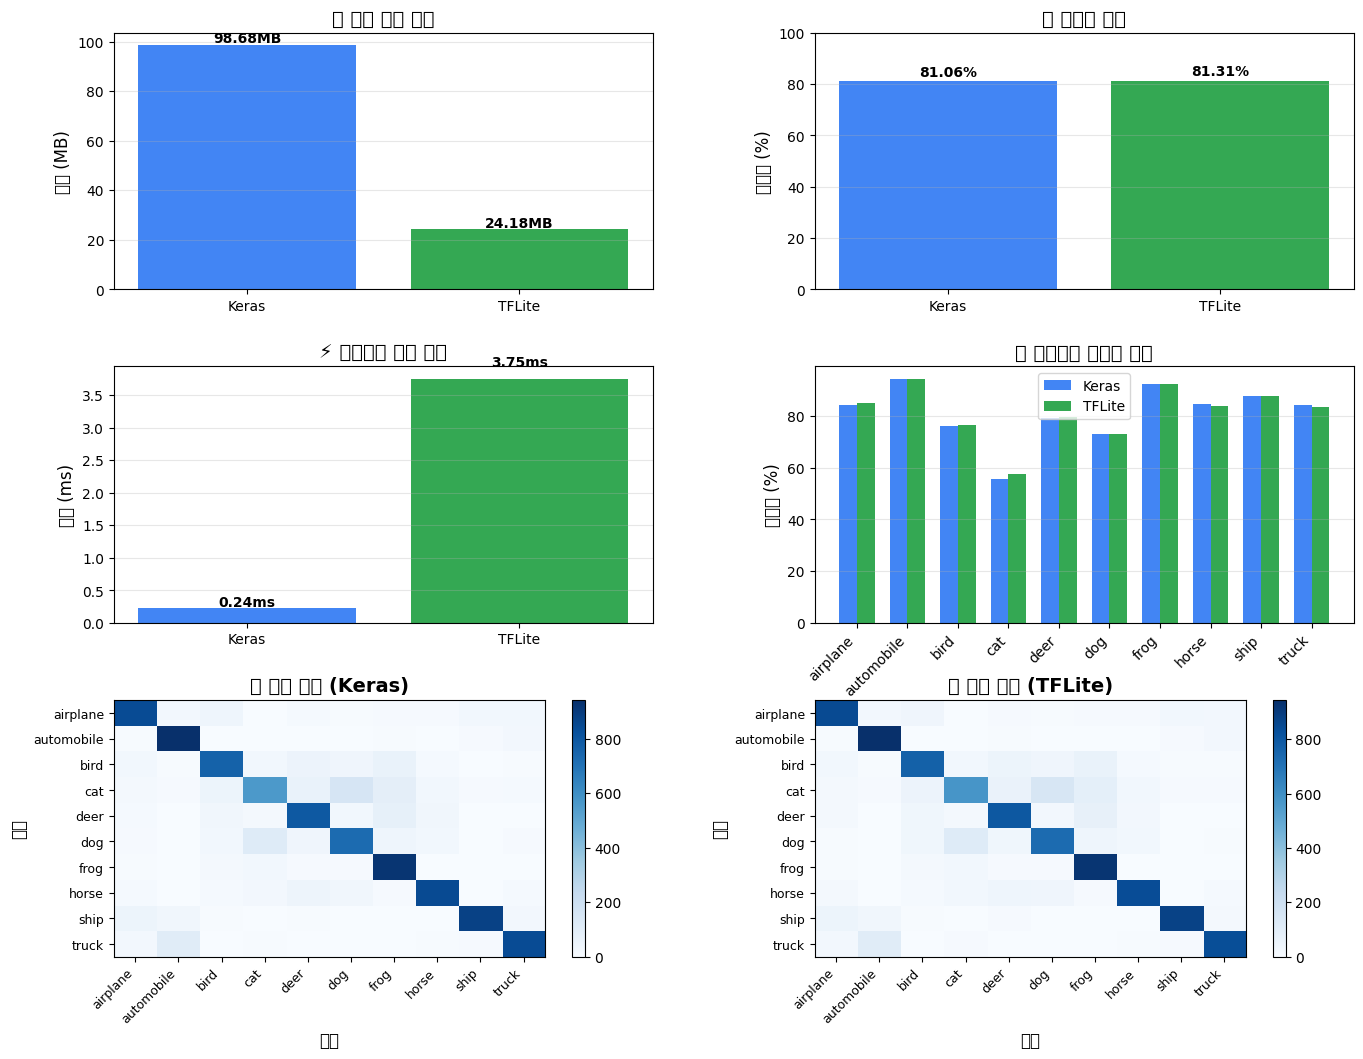


🎉 TFLite 최적화 효과 요약
✅ 모델 크기 75.5% 감소 (98.68MB → 24.18MB)
⚠️  추론 속도 1479.1% 감소 (단일 이미지 추론 시 일반적)
✅ 정확도 거의 동일 (+0.25%p 차이)

💡 모델 정보:
   📌 모델: keras-io/supervised-contrastive-learning-cifar10
   🏗️ 아키텍처: ResNet50V2 + Supervised Contrastive Learning
   📐 입력 크기: 32x32x3 (CIFAR-10 표준)
   🎯 출력: 10개 클래스 (softmax)
   📊 학습 방법: 2단계 학습 (Contrastive + Classification)

🎊 모든 테스트가 완료되었습니다!


In [9]:
# ============================================================================
# 📈 9. 최종 비교 분석
# ============================================================================

print_section("최종 비교 분석", "📈")

# 비교 테이블 출력
print(f"\n{'메트릭':<25} {'Keras 모델':<20} {'TFLite 모델':<20} {'변화율':<15}")
print("="*80)
print(f"{'📦 모델 크기':<25} {keras_results['size_mb']:>12.2f} MB   {tflite_results['size_mb']:>12.2f} MB   {(1-tflite_results['size_mb']/keras_results['size_mb'])*100:>8.1f}% ⬇️")
print(f"{'🎯 정확도':<25} {keras_results['accuracy']*100:>12.2f}%    {tflite_results['accuracy']*100:>12.2f}%    {(tflite_results['accuracy']-keras_results['accuracy'])*100:>8.2f}%p")
print(f"{'⚡ 이미지당 추론시간':<25} {keras_results['avg_time_per_image']:>12.2f} ms   {tflite_results['avg_time_per_image']:>12.2f} ms   ", end="")

speed_change = (keras_results['avg_time_per_image'] - tflite_results['avg_time_per_image']) / keras_results['avg_time_per_image'] * 100
if speed_change > 0:
    print(f"{speed_change:>8.1f}% ⬇️")
else:
    print(f"{abs(speed_change):>8.1f}% ⬆️")

print(f"{'💻 CPU 사용량':<25} {keras_results['cpu_percent']:>12.1f}%    {tflite_results['cpu_percent']:>12.1f}%")
print(f"{'🧠 메모리 사용량':<25} {keras_results['memory_mb']:>12.1f} MB   {tflite_results['memory_mb']:>12.1f} MB")
print("="*80)

# # 시각화
# fig = plt.figure(figsize=(16, 12))
# gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
#
# # 1. 모델 크기 비교
# ax1 = fig.add_subplot(gs[0, 0])
# bars = ax1.bar(['Keras', 'TFLite'], [keras_results['size_mb'], tflite_results['size_mb']],
#                color=['#4285F4', '#34A853'])
# ax1.set_ylabel('크기 (MB)', fontsize=12)
# ax1.set_title('📦 모델 크기 비교', fontsize=14, fontweight='bold')
# ax1.grid(axis='y', alpha=0.3)
# for i, v in enumerate([keras_results['size_mb'], tflite_results['size_mb']]):
#     ax1.text(i, v + 1, f'{v:.2f}MB', ha='center', fontweight='bold')

# # 2. 정확도 비교
# ax2 = fig.add_subplot(gs[0, 1])
# bars = ax2.bar(['Keras', 'TFLite'], [keras_results['accuracy']*100, tflite_results['accuracy']*100],
#                color=['#4285F4', '#34A853'])
# ax2.set_ylabel('정확도 (%)', fontsize=12)
# ax2.set_title('🎯 정확도 비교', fontsize=14, fontweight='bold')
# ax2.set_ylim([0, 100])
# ax2.grid(axis='y', alpha=0.3)
# for i, v in enumerate([keras_results['accuracy']*100, tflite_results['accuracy']*100]):
#     ax2.text(i, v + 2, f'{v:.2f}%', ha='center', fontweight='bold')

# # 3. 추론 시간 비교
# ax3 = fig.add_subplot(gs[1, 0])
# bars = ax3.bar(['Keras', 'TFLite'], [keras_results['avg_time_per_image'], tflite_results['avg_time_per_image']],
#                color=['#4285F4', '#34A853'])
# ax3.set_ylabel('시간 (ms)', fontsize=12)
# ax3.set_title('⚡ 이미지당 추론 시간', fontsize=14, fontweight='bold')
# ax3.grid(axis='y', alpha=0.3)
# for i, v in enumerate([keras_results['avg_time_per_image'], tflite_results['avg_time_per_image']]):
#     ax3.text(i, v * 1.05, f'{v:.2f}ms', ha='center', fontweight='bold')

# # 4. 클래스별 정확도 비교
# ax4 = fig.add_subplot(gs[1, 1])
# class_accuracies_keras = []
# class_accuracies_tflite = []
# for cls_idx in range(10):
#     cls_mask = true_labels == cls_idx
#     class_accuracies_keras.append(np.mean(predicted_labels[cls_mask] == true_labels[cls_mask]) * 100)
#     class_accuracies_tflite.append(np.mean(predicted_labels_tflite[cls_mask] == true_labels[cls_mask]) * 100)

# x = np.arange(len(class_names))
# width = 0.35
# ax4.bar(x - width/2, class_accuracies_keras, width, label='Keras', color='#4285F4')
# ax4.bar(x + width/2, class_accuracies_tflite, width, label='TFLite', color='#34A853')
# ax4.set_ylabel('정확도 (%)', fontsize=12)
# ax4.set_title('📊 클래스별 정확도 비교', fontsize=14, fontweight='bold')
# ax4.set_xticks(x)
# ax4.set_xticklabels(class_names, rotation=45, ha='right')
# ax4.legend()
# ax4.grid(axis='y', alpha=0.3)

# # 5. 혼동 행렬 (Keras)
# ax5 = fig.add_subplot(gs[2, 0])
# im1 = ax5.imshow(cm, cmap='Blues', aspect='auto')
# ax5.set_xticks(range(10))
# ax5.set_yticks(range(10))
# ax5.set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
# ax5.set_yticklabels(class_names, fontsize=9)
# ax5.set_xlabel('예측', fontsize=12)
# ax5.set_ylabel('실제', fontsize=12)
# ax5.set_title('📊 혼동 행렬 (Keras)', fontsize=14, fontweight='bold')
# plt.colorbar(im1, ax=ax5)

# # 6. 혼동 행렬 (TFLite)
# ax6 = fig.add_subplot(gs[2, 1])
# im2 = ax6.imshow(cm_tflite, cmap='Blues', aspect='auto')
# ax6.set_xticks(range(10))
# ax6.set_yticks(range(10))
# ax6.set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
# ax6.set_yticklabels(class_names, fontsize=9)
# ax6.set_xlabel('예측', fontsize=12)
# ax6.set_ylabel('실제', fontsize=12)
# ax6.set_title('📊 혼동 행렬 (TFLite)', fontsize=14, fontweight='bold')
# plt.colorbar(im2, ax=ax6)

# plt.show()

# 최종 요약
print("\n" + "="*80)
print("🎉 TFLite 최적화 효과 요약")
print("="*80)
size_reduction = (1 - tflite_results['size_mb'] / keras_results['size_mb']) * 100
print(f"✅ 모델 크기 {size_reduction:.1f}% 감소 ({keras_results['size_mb']:.2f}MB → {tflite_results['size_mb']:.2f}MB)")

if speed_change > 0:
    print(f"✅ 추론 속도 {speed_change:.1f}% 향상")
else:
    print(f"⚠️  추론 속도 {abs(speed_change):.1f}% 감소 (단일 이미지 추론 시 일반적)")

acc_change = (tflite_results['accuracy'] - keras_results['accuracy']) * 100
if abs(acc_change) < 1:
    print(f"✅ 정확도 거의 동일 ({acc_change:+.2f}%p 차이)")
else:
    print(f"⚠️  정확도 {acc_change:+.2f}%p 변화")

print("="*80)
print("\n💡 모델 정보:")
print(f"   📌 모델: keras-io/supervised-contrastive-learning-cifar10")
print(f"   🏗️ 아키텍처: ResNet50V2 + Supervised Contrastive Learning")
print(f"   📐 입력 크기: 32x32x3 (CIFAR-10 표준)")
print(f"   🎯 출력: 10개 클래스 (softmax)")
print(f"   📊 학습 방법: 2단계 학습 (Contrastive + Classification)")
print("\n🎊 모든 테스트가 완료되었습니다!")